# Model Interpretability with LIME and SHAP

This notebook demonstrates how to explain AI model predictions using LIME and SHAP, and compares them with inherently interpretable models like decision trees.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import lime
import lime.lime_tabular
import shap

# Set random seed for reproducibility
np.random.seed(42)

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## Generate Synthetic Dataset

We'll create a synthetic dataset representing a loan approval system with various features.

In [49]:
# Generate synthetic data
n_samples = 1000

# Generate features
income = np.random.normal(60000, 20000, n_samples)
age = np.random.normal(40, 10, n_samples)
years_employed = np.random.normal(10, 5, n_samples)
debt_ratio = np.random.normal(0.3, 0.1, n_samples)
credit_score = np.random.normal(700, 50, n_samples)

# Create feature matrix
X = np.column_stack([income, age, years_employed, debt_ratio, credit_score])

# Generate target (loan approval) based on a complex rule
y = (credit_score > 720) & \
    ((income > 50000) | (years_employed > 5)) & \
    (debt_ratio < 0.4)

# Create DataFrame
feature_names = ['Income', 'Age', 'Years_Employed', 'Debt_Ratio', 'Credit_Score']
df = pd.DataFrame(X, columns=feature_names)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Train Models

We'll train both a Random Forest (black-box model) and a Decision Tree (interpretable model).

In [50]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

print(f"Random Forest Accuracy: {rf_model.score(X_test_scaled, y_test):.3f}")
print(f"Decision Tree Accuracy: {dt_model.score(X_test_scaled, y_test):.3f}")

Random Forest Accuracy: 0.985
Decision Tree Accuracy: 1.000


## Decision Tree Visualization

Now let's visualize the decision tree for comparison with the black-box model explanations.

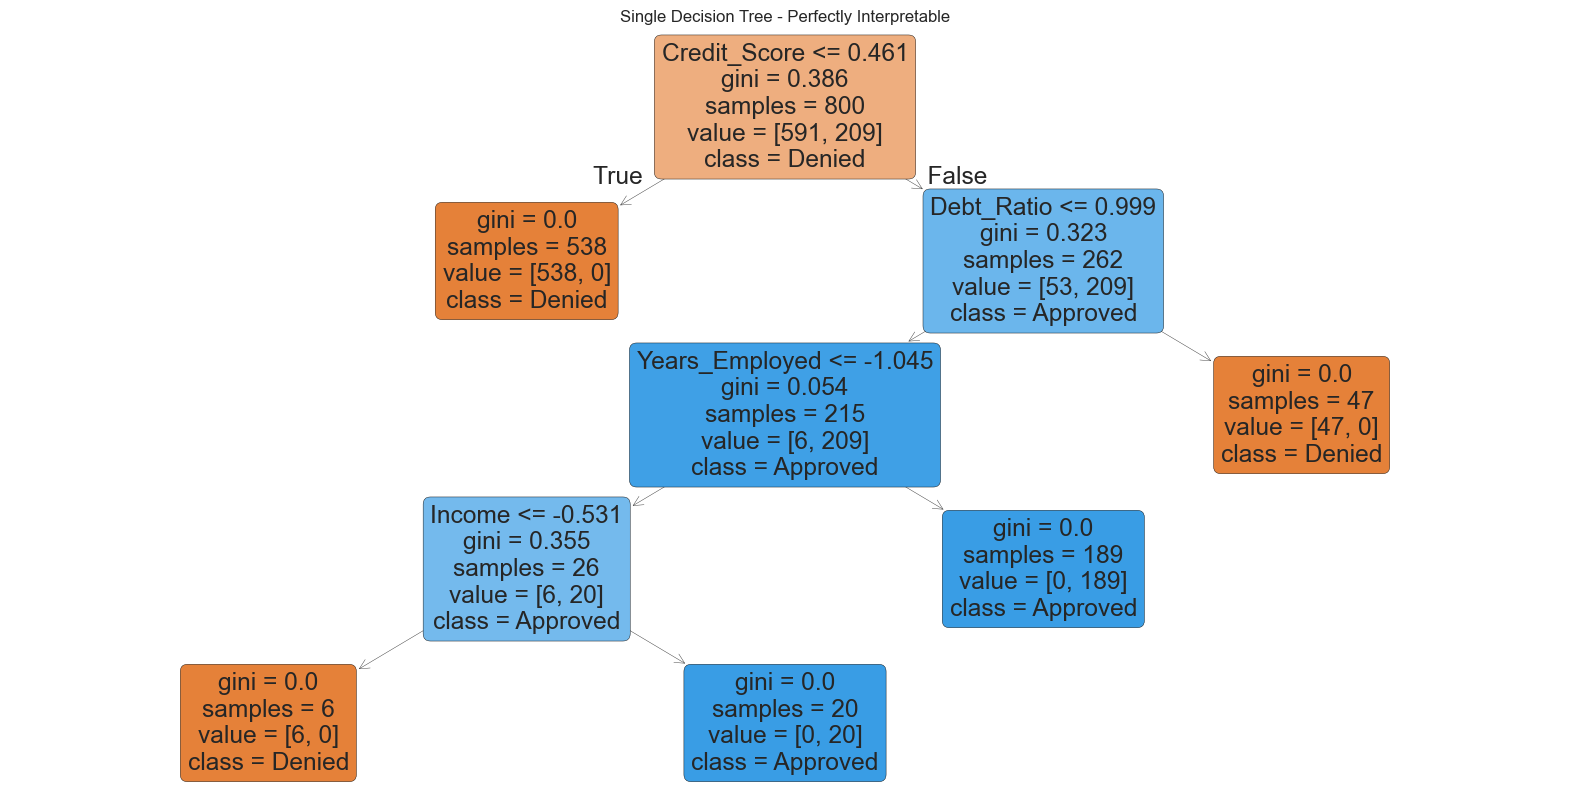

In [51]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, 
         feature_names=feature_names,  # Using the feature_names list we defined earlier
         class_names=['Denied', 'Approved'],  # Changed to match loan approval context
         filled=True,
         rounded=True)
plt.title('Single Decision Tree - Perfectly Interpretable')
plt.show()

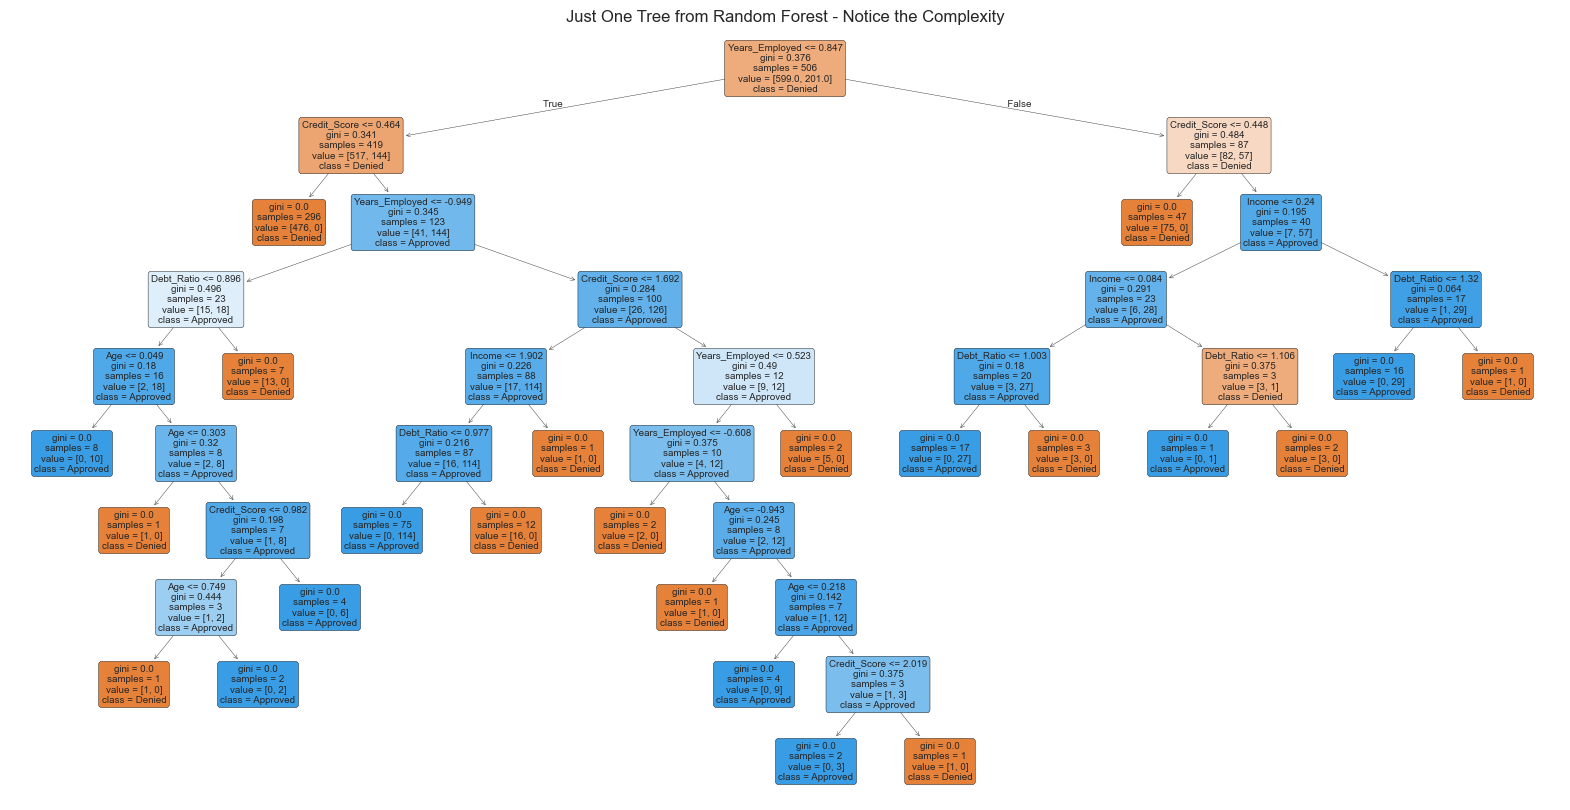

In [52]:
# Visualize one tree from Random Forest to show complexity
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], 
         feature_names=feature_names,  # Using the feature_names list we defined earlier
         class_names=['Denied', 'Approved'],  # Changed to match loan approval context
         filled=True,
         rounded=True)
plt.title('Just One Tree from Random Forest - Notice the Complexity')
plt.show()

## LIME Explanation

Let's use LIME to explain predictions for a specific test case. Note that the order of the features chosen for making decision in the tree above aligns with the feature importance order shown in the LIME for RF model, both derived from the same data where the machine learn from.

<Figure size 1000x600 with 0 Axes>

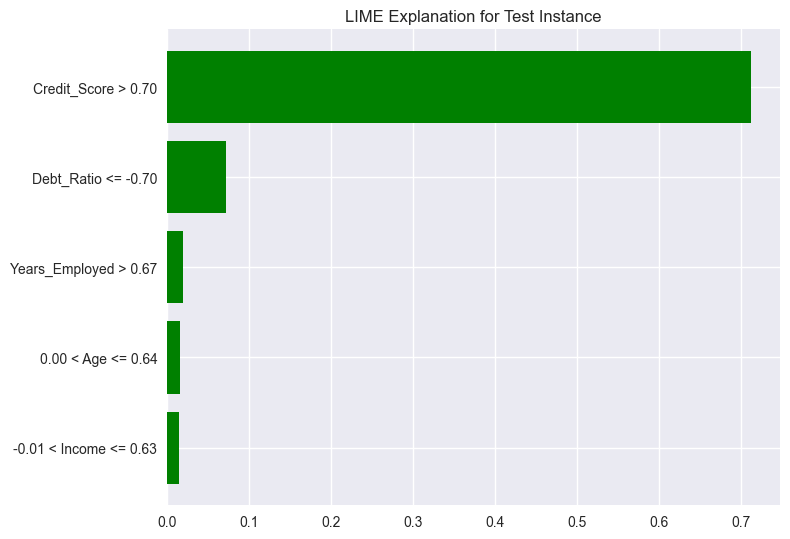

In [53]:
# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    class_names=['Denied', 'Approved'],
    mode='classification'
)

# Select a test case
test_idx = 0
test_instance = X_test_scaled[test_idx]

# Generate LIME explanation
exp = explainer.explain_instance(
    test_instance, 
    rf_model.predict_proba,
    num_features=len(feature_names)
)

# Plot LIME explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation for Test Instance')
plt.tight_layout()
plt.show()

## SHAP Analysis

Now let's use SHAP to understand feature importance and individual predictions.

In [54]:


# 1. Print detailed information
print("Model type:", type(rf_model))
print("X_test_scaled type:", type(X_test_scaled))
print("X_test_scaled shape:", X_test_scaled.shape)

# 2. Create explainer
explainer = shap.TreeExplainer(rf_model)

# 3. Get SHAP values for a single prediction and print its structure
single_prediction = X_test_scaled[0].reshape(1, -1)
shap_values = explainer.shap_values(single_prediction)

print("\nSHAP values details:")
print("Type:", type(shap_values))
print("Value:", shap_values)
if isinstance(shap_values, list):
    print("\nList contents:")
    for i, sv in enumerate(shap_values):
        print(f"Element {i} shape:", sv.shape)
        print(f"Element {i} values:", sv)
else:
    print("Shape:", shap_values.shape)
    print("Values:", shap_values)

print("\nExplainer expected_value:", explainer.expected_value)

# Let's print the actual prediction for this sample
print("\nModel prediction for this sample:")
print(rf_model.predict_proba(single_prediction))

Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
X_test_scaled type: <class 'numpy.ndarray'>
X_test_scaled shape: (200, 5)

SHAP values details:
Type: <class 'numpy.ndarray'>
Value: [[[-0.00685697  0.00685697]
  [-0.01156217  0.01156217]
  [-0.04505229  0.04505229]
  [-0.09622997  0.09622997]
  [-0.55656111  0.55656111]]]
Shape: (1, 5, 2)
Values: [[[-0.00685697  0.00685697]
  [-0.01156217  0.01156217]
  [-0.04505229  0.04505229]
  [-0.09622997  0.09622997]
  [-0.55656111  0.55656111]]]

Explainer expected_value: [0.7362625 0.2637375]

Model prediction for this sample:
[[0.02 0.98]]


SHAP values shape: (200, 5, 2)
X_test_scaled shape: (200, 5)


/var/folders/kc/v5fb6mr50tv0hgk1427rt1gr0000gp/T/ipykernel_7603/3099489199.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


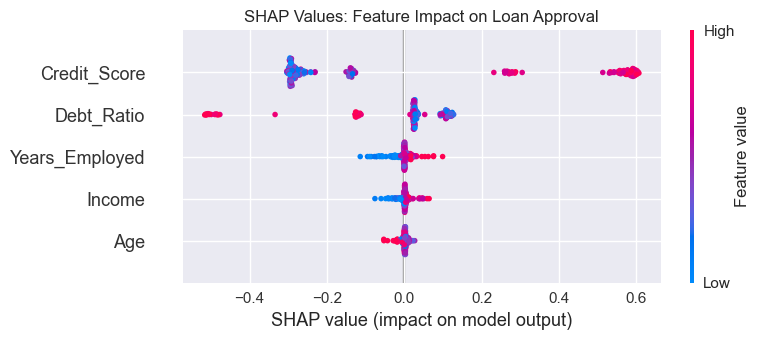


Feature Importance (based on mean absolute SHAP values):
Income          0.008918
Age             0.005661
Years_Employed  0.014547
Debt_Ratio      0.100715
Credit_Score    0.350797


In [55]:


# 1. Create explainer
explainer = shap.TreeExplainer(rf_model)

# 2. Get SHAP values for all test data
shap_values = explainer.shap_values(X_test_scaled)

# Print shapes to verify
print("SHAP values shape:", shap_values.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# 3. Extract the positive class values (second column)
shap_values_positive = shap_values[:, :, 1]

# 4. Create DataFrame for feature values
feature_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# 5. Create the summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values_positive,
    feature_df,
    show=False
)
plt.title("SHAP Values: Feature Impact on Loan Approval")
plt.tight_layout()
plt.show()

# 6. Print feature importance
print("\nFeature Importance (based on mean absolute SHAP values):")
mean_abs_shap = np.abs(shap_values_positive).mean(axis=0)
for fname, importance in zip(feature_names, mean_abs_shap):
    print(f"{fname:15} {importance:.6f}")

### Understanding the SHAP Summary Plot

This visualization shows how each feature impacts the model's prediction of loan approval. Let's break down what we're seeing:

#### How to Read the Plot:
1. **Feature Order**: Features are ordered from top to bottom by their importance (magnitude of impact)
2. **Dots**: Each dot represents one loan application in our test set
3. **Color Coding**:
   - Red dots = High feature values
   - Blue dots = Low feature values
4. **Position on X-axis**:
   - Dots to the right (positive SHAP values) → Increase probability of loan approval
   - Dots to the left (negative SHAP values) → Decrease probability of loan approval

#### Feature Impact Analysis:
- **Credit Score**: The most influential feature
  - High credit scores (red) strongly push towards approval (right)
  - Low credit scores (blue) strongly push towards denial (left)
  
- **Debt Ratio**: Second most important feature
  - High debt ratios (red) decrease approval chances
  - Low debt ratios (blue) increase approval chances

- **Income**: Shows moderate impact
  - Higher incomes generally favor approval
  - Lower incomes tend to decrease approval chances

- **Years Employed**: Similar importance to income
  - Longer employment history slightly increases approval chances
  - Shorter employment duration slightly decreases chances

- **Age**: Shows the least impact
  - Age appears to have minimal influence on the loan decision

#### Key Insights:
1. The model heavily weights Credit Score and Debt Ratio in making decisions
2. Financial factors (Credit Score, Debt Ratio, Income) are more important than demographic factors (Age)
3. The relationship between features and predictions is generally intuitive and aligns with common lending practices

This visualization helps ensure the model's decision-making process is transparent and reasonable, showing that it relies most heavily on relevant financial indicators rather than potentially discriminatory factors like age.

## Conclusion

This notebook demonstrates three different approaches to model interpretability:

1. **Decision Trees**: Provides inherent interpretability through a hierarchical structure
2. **LIME**: Provides local explanations by approximating the model's behavior around specific instances
3. **SHAP**: Offers both global and local interpretability through Shapley values

Each method has its strengths:
- Decision trees offer direct interpretability but might sacrifice some performance
- LIME is great for understanding individual predictions
- SHAP provides consistent and theoretically sound feature importance


The choice of method depends on your specific needs for model interpretation and the trade-off between model performance and interpretability.